<a href="https://colab.research.google.com/github/LxNexis/RM_SalaryPrediction/blob/main/RM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sb
import re
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, recall_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
data = pd.read_csv("ds_salaries.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [ ]:
data.duplicated().sum()

1171

In [ ]:
data = data.drop_duplicates()
data = data.drop(columns=['salary'])

In [ ]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]

    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

#Apply the function to the 'job_title' column and create a new column 'job_category'
# data['job_category'] = data['job_title'].apply(assign_broader_category)

In [ ]:
# Inflation rates
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Function to adjust salary
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2024:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

# Apply the function to the dataset
data['adjusted_salary'] = data.apply(adjust_salary, axis=1)

In [ ]:
data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,adjusted_salary
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,85847.000000
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,30000.000000
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,25500.000000
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,175000.000000
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,120000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L,465053.312718
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L,168373.305000
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S,118520.868532
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L,112877.017650


In [ ]:
numerical_columns = data.select_dtypes(exclude=['object']).columns

for x in numerical_columns:
  upperLimit = data[x].std() * 3 + data[x].mean()
  lowerLimit = data[x].mean() - data[x].std() * 3
  data = data.loc[(data[x] <= upperLimit) & (data[x] >= lowerLimit)]

In [ ]:
data.describe()

,work_year,salary_in_usd,remote_ratio,adjusted_salary,is_EN,is_EX,is_MI,is_SE,is_CT,is_FL,...,is_GBP,is_HKD,is_HUF,is_INR,is_JPY,is_PLN,is_SGD,is_THB,is_TRY,is_USD
count,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,...,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000
mean,2022.369775,132610.643891,50.080386,137453.145764,0.099678,0.036174,0.252814,0.611334,0.003215,0.003617,...,0.056270,0.000402,0.000804,0.021704,0.000804,0.002010,0.002412,0.000804,0.001206,0.823955
std,0.644112,62803.240674,48.333648,64296.248930,0.299631,0.186760,0.434712,0.487545,0.056625,0.060048,...,0.230489,0.020048,0.028347,0.145745,0.028347,0.044793,0.049058,0.028347,0.034710,0.380935
min,2021.000000,5132.000000,0.000000,5583.616000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022.000000,85000.000000,0.000000,90000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2022.000000,130000.000000,50.000000,135000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2023.000000,175000.000000,100.000000,181012.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2023.000000,329500.000000,100.000000,330150.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# numerical_columns = data.select_dtypes(exclude=['object']).columns

# for x in numerical_columns:
#   if x != 'adjusted_salary':
#     data[x] = preprocessing.normalize(np.array(data[x]).reshape(1, -1))[0]

In [ ]:
# data = data.drop(columns=['job_title'])
data = pd.get_dummies(data, columns=['experience_level', 'employment_type', 'company_size', 'company_size','employee_residence', 'job_title', 'company_location', 'salary_currency'], prefix='is')

for column in data.columns:
    if column.startswith('is_'):
        data[column] = data[column].astype(int)

In [ ]:
corr = data.corr()
abss_cor = abs(corr["adjusted_salary"])
high_cor = abss_cor[abss_cor > 0.0]
chosen_feature = [col for col in data.columns if col in high_cor]
chosen_feature.remove('adjusted_salary')
chosen_feature.remove('salary_in_usd')
print(chosen_feature)
# chosen_feature.drop("WinePrice")
# print(chosen_feature)

['work_year', 'remote_ratio', 'is_EN', 'is_EX', 'is_MI', 'is_SE', 'is_CT', 'is_FL', 'is_FT', 'is_PT', 'is_L', 'is_M', 'is_S', 'is_L', 'is_M', 'is_S', 'is_AE', 'is_AM', 'is_AR', 'is_AS', 'is_AT', 'is_AU', 'is_BA', 'is_BE', 'is_BG', 'is_BO', 'is_BR', 'is_CA', 'is_CF', 'is_CH', 'is_CL', 'is_CN', 'is_CO', 'is_CR', 'is_CY', 'is_CZ', 'is_DE', 'is_DK', 'is_DO', 'is_DZ', 'is_EE', 'is_EG', 'is_ES', 'is_FI', 'is_FR', 'is_GB', 'is_GH', 'is_GR', 'is_HK', 'is_HR', 'is_HU', 'is_ID', 'is_IE', 'is_IN', 'is_IQ', 'is_IR', 'is_IT', 'is_JE', 'is_JP', 'is_KE', 'is_KW', 'is_LT', 'is_LU', 'is_LV', 'is_MA', 'is_MD', 'is_MK', 'is_MT', 'is_MX', 'is_MY', 'is_NG', 'is_NL', 'is_PH', 'is_PK', 'is_PL', 'is_PR', 'is_PT', 'is_RO', 'is_RS', 'is_RU', 'is_SE', 'is_SG', 'is_SI', 'is_SK', 'is_TH', 'is_TN', 'is_TR', 'is_UA', 'is_US', 'is_UZ', 'is_VN', 'is_3D Computer Vision Researcher', 'is_AI Developer', 'is_AI Programmer', 'is_AI Scientist', 'is_Analytics Engineer', 'is_Applied Data Scientist', 'is_Applied Machine Learnin

In [ ]:
def wmape(actual, forecast, weights=None):
    actual = np.array(actual)
    forecast = np.array(forecast)

    if weights is None:
        weights = actual

    weights = np.array(weights)

    numerator = np.sum(weights * np.abs(forecast - actual))
    denominator = np.sum(weights * actual)

    wmape_value = (numerator / denominator) * 100
    return wmape_value

def smape(actual, forecast):
    # Convert inputs to numpy arrays
    actual = np.array(actual)
    forecast = np.array(forecast)

    # Calculate the numerator and denominator
    numerator = np.abs(forecast - actual)
    denominator = (np.abs(actual) + np.abs(forecast)) / 2

    # Calculate sMAPE
    smape_value = np.mean(numerator / denominator) * 100

    return smape_value

def relative_absolute_error(y_true, y_pred):
    y_mean = np.mean(y_true)

    abs_error_model = np.abs(y_true - y_pred)
    abs_error_baseline = np.abs(y_true - y_mean)

    rae = np.sum(abs_error_model) / np.sum(abs_error_baseline)
    return rae

In [ ]:
X = data[chosen_feature]
Y = data['adjusted_salary']

In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.2, random_state = 42)

Mean Absolute Error: 39780.89
Mean Absolute Percentage Error: 34.57%
R-squared Score: 0.40
Adjusted R-squared Score: -2.79
sMAPE: 29.96%
WMAPE: 26.89%
Relative Absolute Error (RAE): 0.7467426167902582


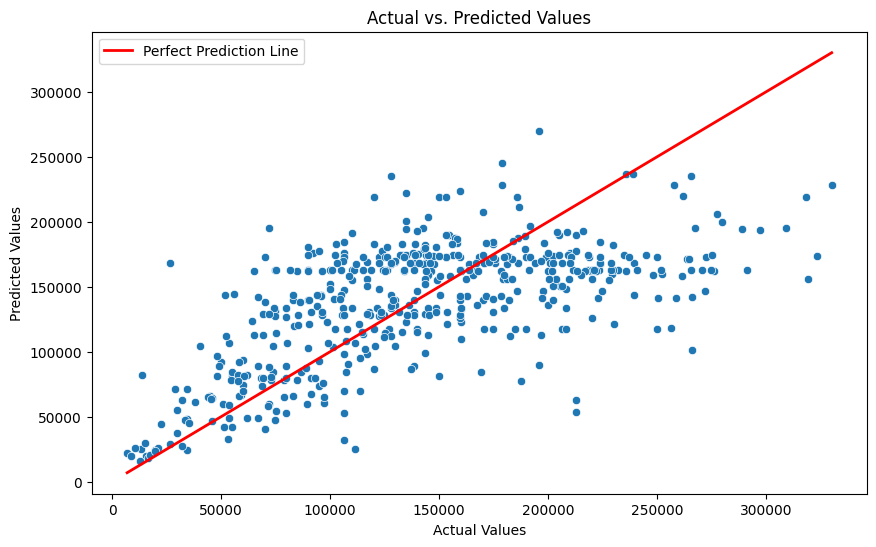

In [ ]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain, YTrain)

predictions = model.predict(XTest)
mae = mean_absolute_error(YTest, predictions)
mape = mean_absolute_percentage_error(YTest, predictions) * 100
r2 = r2_score(YTest, predictions)
n = len(YTest)  # Number of observations
p = XTest.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')
rae = relative_absolute_error(YTest, predictions)
print(f"Relative Absolute Error (RAE): {rae}")

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest), max(predictions))
min_val = min(min(YTest), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 43470.27
Mean Absolute Percentage Error: 51.13%
R-squared Score: 0.35
Adjusted R-squared Score: -3.09
sMAPE: 34.22%
WMAPE: 25.99%


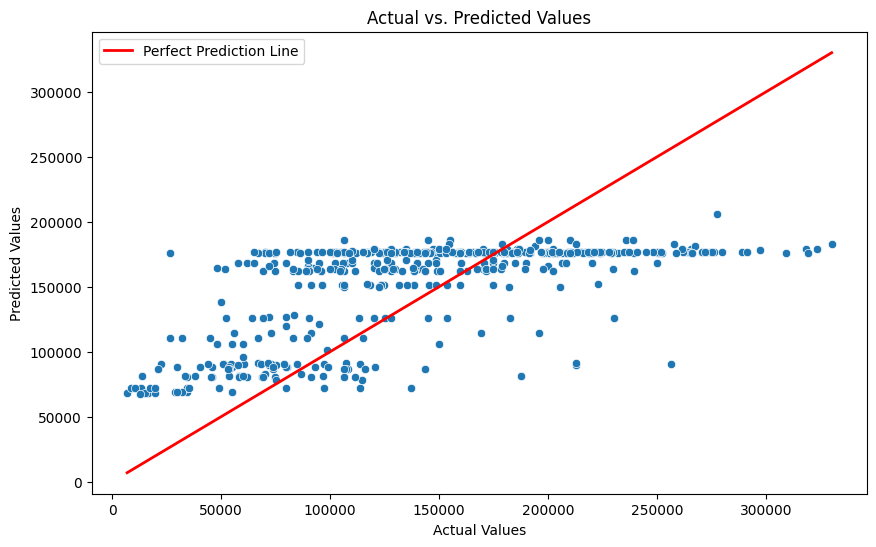

In [ ]:
model = AdaBoostRegressor(n_estimators=200, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain, YTrain)

predictions = model.predict(XTest)
mae = mean_absolute_error(YTest, predictions)
mape = mean_absolute_percentage_error(YTest, predictions) * 100
r2 = r2_score(YTest, predictions)
n = len(YTest)  # Number of observations
p = XTest.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest), max(predictions))
min_val = min(min(YTest), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 38317.36
Mean Absolute Percentage Error: 35.45%
R-squared Score: 0.44
Adjusted R-squared Score: -2.52
sMAPE: 29.12%
WMAPE: 25.87%


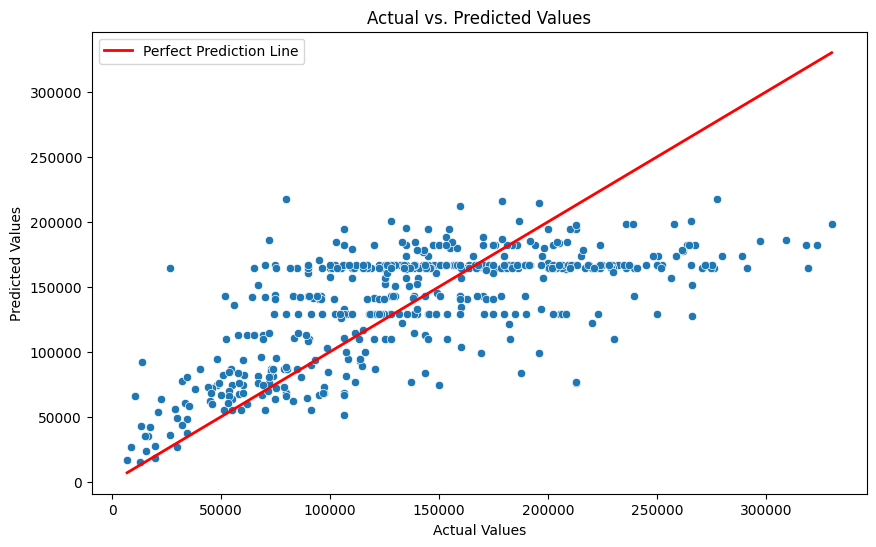

In [ ]:
model = GradientBoostingRegressor(n_estimators=200, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain, YTrain)

predictions = model.predict(XTest)
mae = mean_absolute_error(YTest, predictions)
mape = mean_absolute_percentage_error(YTest, predictions) * 100
r2 = r2_score(YTest, predictions)
n = len(YTest)  # Number of observations
p = XTest.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest), max(predictions))
min_val = min(min(YTest), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 41335.70
Mean Absolute Percentage Error: 35.55%
R-squared Score: 0.36
Adjusted R-squared Score: -3.05
sMAPE: 31.58%
WMAPE: 27.77%


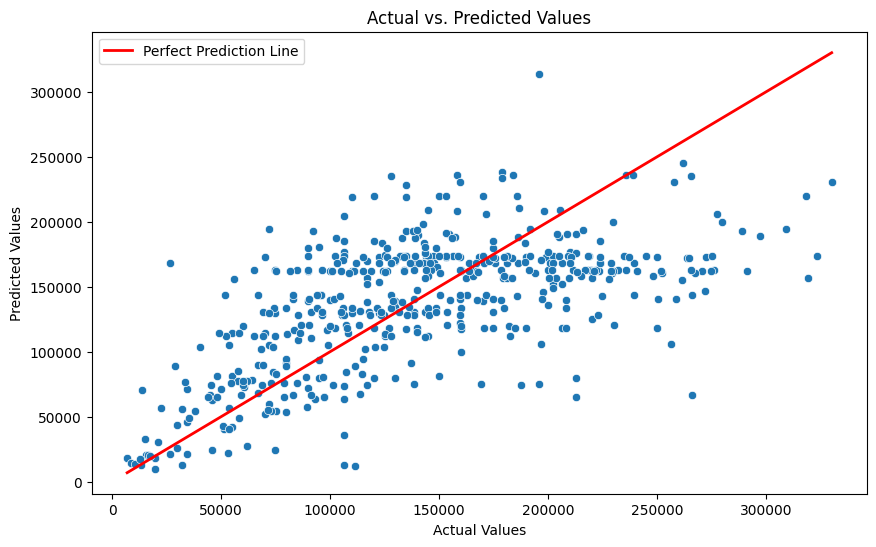

In [ ]:
model = ExtraTreesRegressor(n_estimators=200, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain, YTrain)

predictions = model.predict(XTest)
mae = mean_absolute_error(YTest, predictions)
mape = mean_absolute_percentage_error(YTest, predictions) * 100
r2 = r2_score(YTest, predictions)
n = len(YTest)  # Number of observations
p = XTest.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest), max(predictions))
min_val = min(min(YTest), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

In [ ]:
XTrain_array = XTrain.to_numpy()
XTest_array = XTest.to_numpy()
YTrain_array = YTrain.to_numpy()
YTest_array = YTest.to_numpy()

Mean Absolute Error: 39616.24
Mean Absolute Percentage Error: 35.78%
R-squared Score: 0.41
Adjusted R-squared Score: -2.71
sMAPE: 29.96%
WMAPE: 26.70%


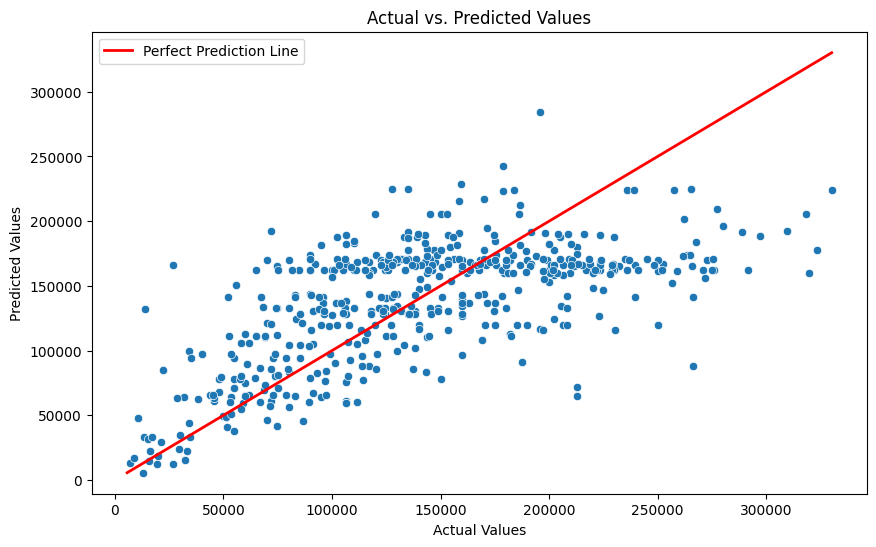

In [ ]:
model = XGBRegressor(n_estimators=200, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain_array, YTrain_array)

predictions = model.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 39182.55
Mean Absolute Percentage Error: 36.41%
R-squared Score: 0.42
Adjusted R-squared Score: -2.63
sMAPE: 29.88%
WMAPE: 26.59%


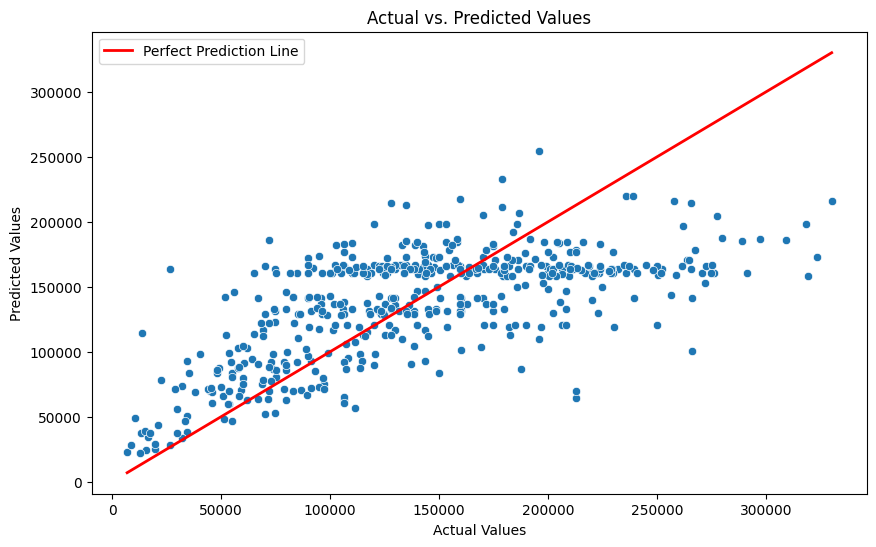

In [ ]:
base_models = [
    ('xgb', XGBRegressor(n_estimators=100, random_state = 42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state = 42))
]
model = StackingRegressor(estimators=base_models, final_estimator=Ridge())
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain_array, YTrain_array)

predictions = model.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 38631.99
Mean Absolute Percentage Error: 34.55%
R-squared Score: 0.44
Adjusted R-squared Score: -2.54
sMAPE: 29.03%
WMAPE: 26.13%


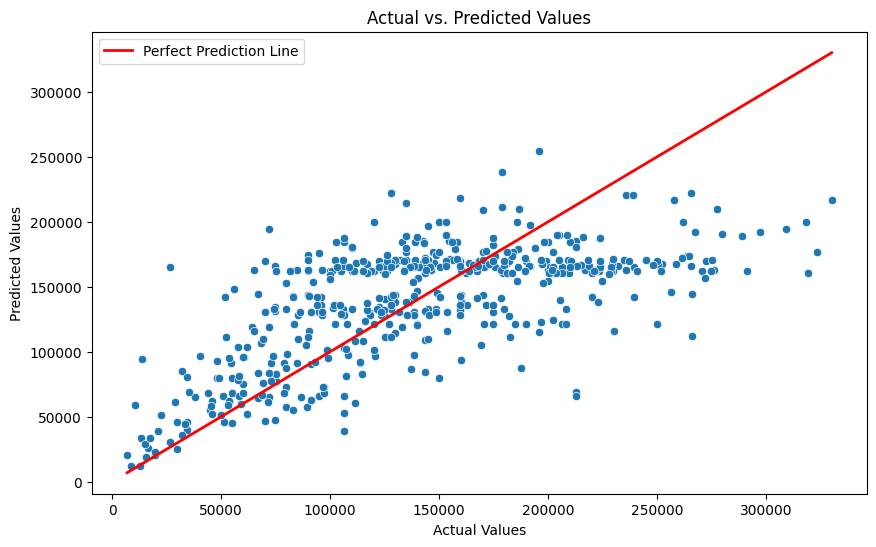

In [ ]:
base_regressor = XGBRegressor(n_estimators=100, random_state=42)
model = BaggingRegressor(estimator=base_regressor, n_estimators=100, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain_array, YTrain_array)
predictions = model.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "nn_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Absolute Error: 39254.52
Mean Absolute Percentage Error: 34.62%
R-squared Score: 0.42
Adjusted R-squared Score: -2.67
sMAPE: 29.47%
WMAPE: 26.57%


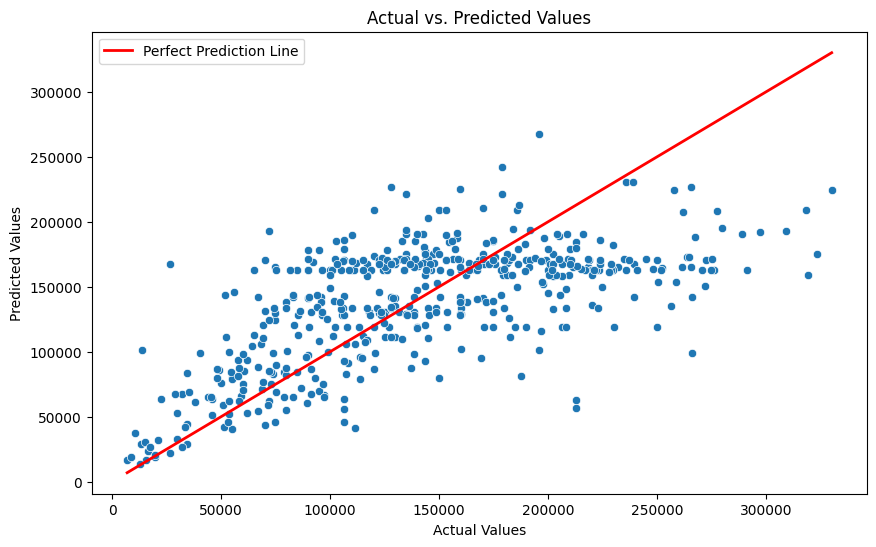

In [ ]:
regressor1 = XGBRegressor(nn_estimators=100, random_state=42)
regressor2 = RandomForestRegressor(n_estimators=100, random_state=42)

model = VotingRegressor(estimators=[('lr', regressor1), ('rf', regressor2)])
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
model.fit(XTrain_array, YTrain_array)

predictions = model.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()